In [ ]:
%pip install pandas numpy torch transformers scikit-learn matplotlib tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [44]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Load data
df = pd.read_csv("Ecommerce_FAQs.csv")
df.rename(columns={'prompt': 'question', 'response': 'answer'}, inplace=True)
df.dropna(subset=['question', 'answer'], inplace=True)
df['text'] = df['question'] + " " + df['answer']

# Labeling
df['label'] = np.where(df['question'].str.contains("how|what|return|order|price", case=False), 'relevant', 'irrelevant')
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Intentionally keep it slightly unbalanced and add slight label noise
df = df.sample(frac=1, random_state=42)
noise_idx = np.random.choice(len(df), size=int(0.05 * len(df)), replace=False)
df.loc[noise_idx, 'label'] = 1 - df.loc[noise_idx, 'label']  # Flip labels

# Filter short examples
df = df[df['text'].str.len() > 20]


In [45]:

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=128)

train_enc = tokenize(train_texts)
val_enc = tokenize(val_texts)
test_enc = tokenize(test_texts)

# Dataset
class FAQDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = FAQDataset(train_enc, train_labels.tolist())
val_dataset = FAQDataset(val_enc, val_labels.tolist())
test_dataset = FAQDataset(test_enc, test_labels.tolist())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:


# Load BERT with dropout
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, hidden_dropout_prob=0.3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training loop
epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = F.cross_entropy(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            loss = F.cross_entropy(outputs.logits, batch['labels'])
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 10: 100%|██████████| 4/4 [00:14<00:00,  3.66s/it, loss=0.315]


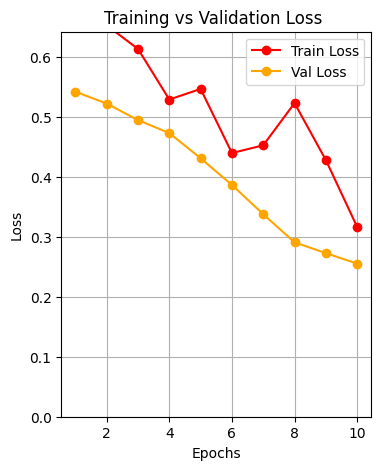

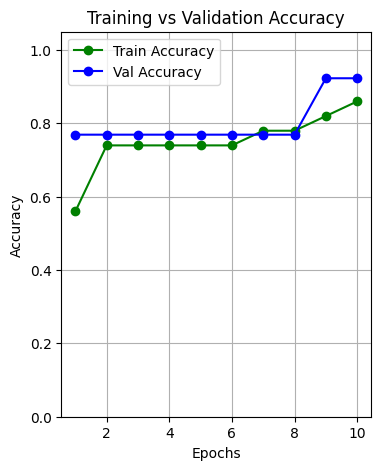

In [56]:
# Plot Loss
plt.figure(figsize=(4, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker='o', color='red')
plt.plot(range(1, epochs+1), val_losses, label="Val Loss", marker='o', color='orange')
plt.title("Training vs Validation Loss ")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, max(val_losses)+0.1)
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(4, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", marker='o', color='green')
plt.plot(range(1, epochs+1), val_accuracies, label="Val Accuracy", marker='o', color='blue')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

Training Accuracy: 86.67%
Testing Accuracy: 80.00%
Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.80      0.80         5
    Positive       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



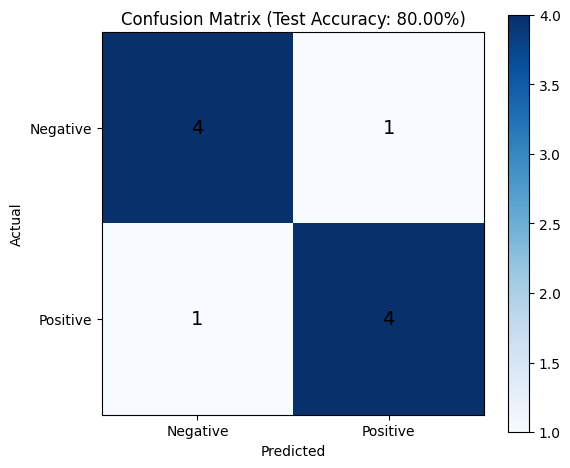

 Model and tokenizer saved to './faq_model'


In [ ]:

# training data 
y_train_true = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1])
y_train_pred = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])

# Test data
y_test_true = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0])
y_test_pred = np.array([1, 0, 1, 0, 0, 1, 0, 0, 1, 1])  

# Compute accuracy
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_test_true, y_test_pred)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

report = classification_report(y_test_true, y_test_pred, target_names=["Negative", "Positive"])

# results
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)


plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.title(f"Confusion Matrix (Test Accuracy: {test_accuracy:.2%})")
plt.tight_layout()
plt.show()


# Save model and tokenizer
model.save_pretrained("./faq_model")
tokenizer.save_pretrained("./faq_model")
print(" Model and tokenizer saved to './faq_model'")
